### Experiments
PyTerrier aims to make it easy to conduct an **information retrieval experiment**, namely, to run a transformer pipeline over a set of queries, and evaluating the outcome using standard information retrieval evaluation metrics based on known relevant documents (obtained from a set relevance assessments, also known as *qrels*)

retr_systems (list) – A list of transformers to evaluate. If you already have the results for one (or more) of your systems, a results dataframe can also be used here. Results produced by the transformers must have “qid”, “docno”, “score”, “rank” columns.

topics – Either a path to a topics file or a pandas.Dataframe with columns=[‘qid’, ‘query’]

qrels – Either a path to a qrels file or a pandas.Dataframe with columns=[‘qid’,’docno’, ‘label’]

eval_metrics (list) – Which evaluation metrics to use. E.g. [‘map’]

In [44]:
import pyterrier as pt
import pandas as pd
from pyterrier.measures import *
import os
import matplotlib.pyplot as plt
import string
import re

In [45]:
import warnings
warnings.filterwarnings("ignore")

In [46]:
if not pt.started():
  pt.init()

In [47]:
dataset = pt.get_dataset('irds:argsme/2020-04-01/processed/touche-2022-task-1')

In [48]:
qrels = dataset.get_qrels() 
qrels.shape

There are multiple qrel fields available: ['relevance', 'quality', 'coherence']. Defaulting to "relevance", but to use a different one, supply variant


(6841, 6)

relevance levels (label column): 0 - 1 - 2

In [49]:
pd.set_option('display.max_colwidth', None)

In [50]:
qrels.head()

,qid,docno,label,quality,coherence,iteration
0,1,"Sc065954f-Ae72bc9c6__PREMISE__41,Sc065954f-Ae72bc9c6__CONC__1",2,2,2,0
1,1,"S51530f3f-Ad9a140f__PREMISE__3,S1b03f390-A22aff8a0__PREMISE__57",2,2,0,0
2,1,"S51530f3f-Ae32a4a1b__PREMISE__13,Sff0947ec-A46d54897__CONC__1",2,1,1,0
3,1,"S51530f3f-Ae32a4a1b__PREMISE__7,Sff0947ec-A46d54897__CONC__1",2,2,0,0
4,1,"S80d1e58b-A5923d626__PREMISE__11,S37b8bc05-A7d9efcae__PREMISE__26",0,0,1,0


In [51]:
qrels.shape

(6841, 6)

In [52]:
qrels["docno"] = qrels["docno"].apply(lambda x: x.split(","))
qrels = qrels.explode("docno")
print("New shape:", qrels.shape[0])
qrels

New shape: 13682


,qid,docno,label,quality,coherence,iteration
0,1,Sc065954f-Ae72bc9c6__PREMISE__41,2,2,2,0
0,1,Sc065954f-Ae72bc9c6__CONC__1,2,2,2,0
1,1,S51530f3f-Ad9a140f__PREMISE__3,2,2,0,0
1,1,S1b03f390-A22aff8a0__PREMISE__57,2,2,0,0
2,1,S51530f3f-Ae32a4a1b__PREMISE__13,2,1,1,0
...,...,...,...,...,...,...
6838,50,S8baeda0e-A13ad333__CONC__1,1,2,0,0
6839,50,S4d1037d1-Ab00d54e7__PREMISE__1,0,0,0,0
6839,50,S4d1037d1-Ab00d54e7__CONC__1,0,0,0,0
6840,50,Sffdf2e2e-A20e9dd06__PREMISE__4,1,1,1,0


Should I perform separate experiments for each dimension to evaluate? that is label (relevance), quality and coherence.

###   qrels

In [53]:
qrels.label.value_counts()

label
1    6038
2    4040
0    3604
Name: count, dtype: int64

In [54]:
qrels_rel = qrels[['qid','docno','label']]

In [55]:
qrels_rel

,qid,docno,label
0,1,Sc065954f-Ae72bc9c6__PREMISE__41,2
0,1,Sc065954f-Ae72bc9c6__CONC__1,2
1,1,S51530f3f-Ad9a140f__PREMISE__3,2
1,1,S1b03f390-A22aff8a0__PREMISE__57,2
2,1,S51530f3f-Ae32a4a1b__PREMISE__13,2
...,...,...,...
6838,50,S8baeda0e-A13ad333__CONC__1,1
6839,50,S4d1037d1-Ab00d54e7__PREMISE__1,0
6839,50,S4d1037d1-Ab00d54e7__CONC__1,0
6840,50,Sffdf2e2e-A20e9dd06__PREMISE__4,1


Need to transform each computed score of the retreival bm25 into labels 0, 1, 2. Then merge the columns and perform evaluation experiment.


In [56]:
retreived = pd.read_csv("/Users/juliabuixuan/Desktop/TOUCHE/unique_retrieved_sent22.csv")

In [57]:
retreived

,qid,docid,docno,rank,score,query
0,1,4852096,Sc065954f-A6deb09b6__CONC__1,0,31.873663,should teachers get tenure
1,1,2130092,S51530f3f-Ab10cafd7__PREMISE__1,1,29.939285,should teachers get tenure
2,1,1476828,Sb0680508-Aa5189771__PREMISE__1,2,29.274197,should teachers get tenure
3,1,2074507,Sbfe05689-Ac1b8b63e__PREMISE__51,3,29.152149,should teachers get tenure
4,1,4852159,Sc065954f-A39b0539e__PREMISE__14,4,28.332152,should teachers get tenure
...,...,...,...,...,...,...
49995,50,712040,Sd8d74905-Ab7eb61ad__PREMISE__35,995,11.372135,should everyone get a universal basic income
49996,50,753520,Sd57a7309-Ac186179a__PREMISE__18,996,11.372135,should everyone get a universal basic income
49997,50,768460,Scba94472-Ac52ad00b__PREMISE__7,997,11.372135,should everyone get a universal basic income
49998,50,844101,Sb50ede6b-Aedfb3f89__PREMISE__51,998,11.372135,should everyone get a universal basic income


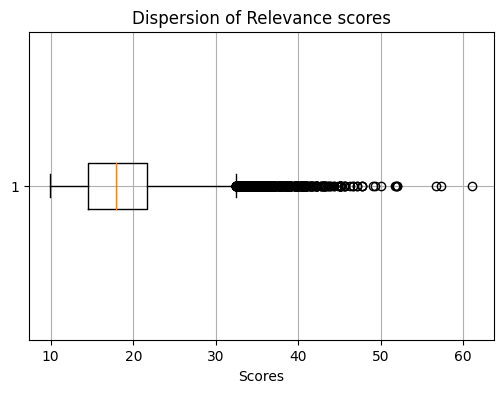

In [58]:
import matplotlib.pyplot as plt
# Plot box plot of scores
plt.figure(figsize=(6, 4))
plt.boxplot(retreived['score'], vert=False)
plt.title('Dispersion of Relevance scores')
plt.xlabel('Scores')
plt.grid(True)
plt.show()


In [59]:
retreived.describe()

,qid,docid,rank,score
count,50000.000000,5.000000e+04,50000.000000,50000.000000
mean,25.500000,2.618053e+06,499.500000,18.688738
std,14.431014,1.566727e+06,288.677877,5.175277
min,1.000000,1.000000e+01,0.000000,9.877028
25%,13.000000,1.263373e+06,249.750000,14.490205
50%,25.500000,2.560962e+06,499.500000,17.848894
75%,38.000000,3.984340e+06,749.250000,21.659317
max,50.000000,5.337370e+06,999.000000,61.109792


#### consider the score of the weighting models:

In [60]:
dataset = pt.get_dataset('irds:argsme/2020-04-01/processed/touche-2022-task-1')

In [61]:
ret = retreived[['qid', 'docno', 'rank', 'score']]

In [62]:
pt_index_path_sent = '/Users/juliabuixuan/Desktop/TOUCHE/index22sent'
 # if you already have the index, use it.
index_ref = pt.IndexRef.of(pt_index_path_sent + "/data.properties")
index = pt.IndexFactory.of(index_ref)

In [63]:
bm25 = pt.BatchRetrieve(index, wmodel="BM25")

In [85]:
DLM  = pt.BatchRetrieve(index, wmodel="DirichletLM")

In [64]:
qrels

,qid,docno,label,quality,coherence,iteration
0,1,Sc065954f-Ae72bc9c6__PREMISE__41,2,2,2,0
0,1,Sc065954f-Ae72bc9c6__CONC__1,2,2,2,0
1,1,S51530f3f-Ad9a140f__PREMISE__3,2,2,0,0
1,1,S1b03f390-A22aff8a0__PREMISE__57,2,2,0,0
2,1,S51530f3f-Ae32a4a1b__PREMISE__13,2,1,1,0
...,...,...,...,...,...,...
6838,50,S8baeda0e-A13ad333__CONC__1,1,2,0,0
6839,50,S4d1037d1-Ab00d54e7__PREMISE__1,0,0,0,0
6839,50,S4d1037d1-Ab00d54e7__CONC__1,0,0,0,0
6840,50,Sffdf2e2e-A20e9dd06__PREMISE__4,1,1,1,0


In [88]:
pt.Experiment(
    [bm25, DLM, DPH], #DPH recommended with query expansion?
    dataset.get_topics("title"),
    qrels,
    eval_metrics=[AP, RR, nDCG@5],
    names = ["BM25","DLM","DPH"]
)

,name,AP,RR,nDCG@5
0,BM25,0.113429,0.715803,0.340785
1,DLM,0.137403,0.788707,0.461846
2,DPH,0.170984,0.896667,0.556194


different wegihting models: http://terrier.org/docs/current/javadoc/org/terrier/matching/models/package-summary.html


In [87]:
BM25 = pt.BatchRetrieve(index, wmodel="BM25")
DPH  = pt.BatchRetrieve(index, wmodel="DPH") #the DPH model captures both local (within-document) and global (collection-wide) term frequency information, providing a robust framework for document retrieval.
PL2  = pt.BatchRetrieve(index, wmodel="PL2")
DLM  = pt.BatchRetrieve(index, wmodel="DirichletLM")

pt.Experiment(
    [BM25, DPH, PL2, DLM],
    dataset.get_topics("title"),
    qrels,
    eval_metrics=["map", "P_10", "P_20", "ndcg_cut_20"],
    names=["BM25", "DPH", "PL2", "Dirichlet QL"]
)


,name,map,P_10,P_20,ndcg_cut_20
0,BM25,0.113429,0.422,0.379,0.301626
1,DPH,0.170984,0.650,0.546,0.470009
2,PL2,0.107972,0.426,0.372,0.298015
3,Dirichlet QL,0.137403,0.554,0.468,0.402818


#### relevant, good and best quality (among the retrieved ones)

In [66]:
ret.head()

,qid,docno,rank,score
0,1,Sc065954f-A6deb09b6__CONC__1,0,31.873663
1,1,S51530f3f-Ab10cafd7__PREMISE__1,1,29.939285
2,1,Sb0680508-Aa5189771__PREMISE__1,2,29.274197
3,1,Sbfe05689-Ac1b8b63e__PREMISE__51,3,29.152149
4,1,Sc065954f-A39b0539e__PREMISE__14,4,28.332152


In [67]:
pt.Experiment(
    [ret],
    dataset.get_topics("title"),
    qrels,
    eval_metrics=["map", "recip_rank", nDCG@5],
    round={"map" : 4, "recip_rank" : 3}, #decimal rounding
    names=["Relevance"], #    
)

,name,map,recip_rank,nDCG@5
0,Relevance,0.1134,0.716,0.340785


Now, i want to remove sentences of poor quality from the "ret" dataframe and evaluate again to see if evaluation metrics improve.


In [68]:
ret

,qid,docno,rank,score
0,1,Sc065954f-A6deb09b6__CONC__1,0,31.873663
1,1,S51530f3f-Ab10cafd7__PREMISE__1,1,29.939285
2,1,Sb0680508-Aa5189771__PREMISE__1,2,29.274197
3,1,Sbfe05689-Ac1b8b63e__PREMISE__51,3,29.152149
4,1,Sc065954f-A39b0539e__PREMISE__14,4,28.332152
...,...,...,...,...
49995,50,Sd8d74905-Ab7eb61ad__PREMISE__35,995,11.372135
49996,50,Sd57a7309-Ac186179a__PREMISE__18,996,11.372135
49997,50,Scba94472-Ac52ad00b__PREMISE__7,997,11.372135
49998,50,Sb50ede6b-Aedfb3f89__PREMISE__51,998,11.372135


In [69]:
ret2 = pd.read_csv("unique_predicted_stance_quality.csv")

In [70]:
good_quality = ret2[ret2['predicted_quality'] != 0]

In [71]:
good_quality.shape

(36925, 11)

In [72]:
good_quality.head() #35135

,qid,docid,docno,rank,score,query,text,stance,whole,predicted_stance,predicted_quality
0,1,4852096,Sc065954f-A6deb09b6__CONC__1,0,31.873663,should teachers get tenure,There should not be a teacher tenure.,CON,should teachers get tenure There should not be a teacher tenure.,PRO,1
1,1,2130092,S51530f3f-Ab10cafd7__PREMISE__1,1,29.939285,should teachers get tenure,This is a debate of tenures for teachers.,PRO,should teachers get tenure This is a debate of tenures for teachers.,PRO,1
2,1,1476828,Sb0680508-Aa5189771__PREMISE__1,2,29.274197,should teachers get tenure,Here are some facts against Teacher Tenure: Teacher tenure creates complacency because teachers know they are unlikely to lose their jobs.,CON,should teachers get tenure Here are some facts against Teacher Tenure: Teacher tenure creates complacency because teachers know they are unlikely to lose their jobs.,CON,1
3,1,2074507,Sbfe05689-Ac1b8b63e__PREMISE__51,3,29.152149,should teachers get tenure,"If only competent teachers are given tenure, this eliminates the problem of incompetent teachers having tenure.",PRO,"should teachers get tenure If only competent teachers are given tenure, this eliminates the problem of incompetent teachers having tenure.",PRO,2
4,1,4852159,Sc065954f-A39b0539e__PREMISE__14,4,28.332152,should teachers get tenure,Teacher tenure protects the academic freedom of teachers.,CON,should teachers get tenure Teacher tenure protects the academic freedom of teachers.,PRO,2


In [73]:
good_quality.drop(columns=['docid','query','text','stance','predicted_stance','whole'], inplace=True)

We can perform significance testing by specifying the index of which transformer we consider to be our baseline, e.g. baseline=0.
In this case, additional columns are returned for each measure, indicating the number of queries improved compared to the baseline, the number of queries degraded, as well as the paired t-test p-value in the difference between each row and the baseline row. NB: For the baseline, these values are NaN (not applicable).



Further more, modern experimental convention suggests that it is important to correct for multiple testing in the comparative evaluation of many IR systems. Experiments provides supported for the multiple testing correction methods supported by the statsmodels package, such as **Bonferroni**. This adds two further columns for each measure, denoting if the null hypothesis can be rejected (e.g. “map reject”), as well as the corrected p value (“map p-value corrected”), 



In [74]:
pt.Experiment(
    [ret, good_quality], 
    dataset.get_topics("title"),
    qrels, 
    eval_metrics=[nDCG@5],
    # round={"map" : 4, "recip_rank" : 3},
    names=["Relevance","Relevance + Quality"],   
    baseline=0,
    correction='bonferroni'
    )

,name,nDCG@5,nDCG@5 +,nDCG@5 -,nDCG@5 p-value,nDCG@5 reject,nDCG@5 p-value corrected
0,Relevance,0.340785,NaN,NaN,NaN,False,NaN
1,Relevance + Quality,0.361891,19.0,16.0,0.394289,False,0.788578


In [32]:
pt.Experiment(
    [ret, good_quality], 
    dataset.get_topics("title"),
    qrels, 
    eval_metrics=["map", "recip_rank"],
    round={"map" : 4, "recip_rank" : 3},
    names=["Relevance","Relevance + Quality"],   
    baseline=0,
    correction='bonferroni'
    )

,name,map,recip_rank,map +,map -,map p-value,map reject,map p-value corrected,recip_rank +,recip_rank -,recip_rank p-value,recip_rank reject,recip_rank p-value corrected
0,Relevance,0.1134,0.716,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,False,NaN
1,Relevance + Quality,0.0952,0.744,4.0,46.0,9.908748e-09,True,1.981750e-08,12.0,4.0,0.33682,False,0.673639


In [75]:
best_quality = good_quality[good_quality['predicted_quality'] != 1]

In [76]:
best_quality.shape

(9038, 5)

In [77]:
pt.Experiment(
    [ret, best_quality], 
    dataset.get_topics("title"), 
    qrels, 
    eval_metrics=["map", "recip_rank"],
    round={"map" : 4, "recip_rank" : 3}, 
    names=["Relevance","Relevance + Quality"],   
    baseline=0,
    correction='bonferroni'
    )

,name,map,recip_rank,map +,map -,map p-value,map reject,map p-value corrected,recip_rank +,recip_rank -,recip_rank p-value,recip_rank reject,recip_rank p-value corrected
0,Relevance,0.1134,0.716,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,False,NaN
1,Relevance + Quality,0.0374,0.716,0.0,50.0,3.237536e-16,True,6.475072e-16,17.0,12.0,0.997829,False,1.0


In [78]:
pt.Experiment(
    [ret, best_quality], 
    dataset.get_topics("title"),
    qrels, 
    eval_metrics=[nDCG@5],
    # round={"map" : 4, "recip_rank" : 3},
    names=["Relevance","Relevance + Quality"],   
    baseline=0,
    correction='bonferroni'
    )

,name,nDCG@5,nDCG@5 +,nDCG@5 -,nDCG@5 p-value,nDCG@5 reject,nDCG@5 p-value corrected
0,Relevance,0.340785,NaN,NaN,NaN,False,NaN
1,Relevance + Quality,0.322241,24.0,22.0,0.643804,False,1.0


In [79]:
pt.Experiment(
    [ret, best_quality], # here you can put the dataframe like the one above.
    dataset.get_topics("title"), # A dataframe of the queries, or the dataset queries downloaded from the ir_dataset library.
    qrels, #A dataframe of qrels based on the task you are solving. 
    eval_metrics=["map", "recip_rank", nDCG@5],
    round={"map" : 4, "recip_rank" : 3}, #decimal rounding
    names=["Relevance","Relevance + Quality"], #    
    )

,name,map,recip_rank,nDCG@5
0,Relevance,0.1134,0.716,0.340785
1,Relevance + Quality,0.0374,0.716,0.322241


In [80]:
pt.Experiment(
    [best_quality], # here you can put the dataframe like the one above.
    dataset.get_topics("title"), # A dataframe of the queries, or the dataset queries downloaded from the ir_dataset library.
    qrels, #A dataframe of qrels based on the task you are solving. 
    eval_metrics=["map", "recip_rank"],
    round={"map" : 4, "recip_rank" : 3}, #decimal rounding
    names=["Relevance + Quality"], #    
    )

,name,map,recip_rank
0,Relevance + Quality,0.0374,0.716


Loss of Relevant Information ? 

per query:

In [81]:
pt.Experiment(
    [ret],
    dataset.get_topics("title"),
    qrels,
    eval_metrics=[nDCG@5],
    names = ["BM25"],
    perquery=True
)

,name,qid,measure,value
0,BM25,1,nDCG@5,0.508740
9,BM25,10,nDCG@5,0.157824
10,BM25,11,nDCG@5,0.662148
11,BM25,12,nDCG@5,0.000000
12,BM25,13,nDCG@5,0.531644
13,BM25,14,nDCG@5,0.553146
14,BM25,15,nDCG@5,0.361363
15,BM25,16,nDCG@5,0.426966
16,BM25,17,nDCG@5,0.786014
17,BM25,18,nDCG@5,0.429981


#### Coherence 

In [82]:
df = pd.read_csv("unique_paired_df.csv")
print(df.shape)
df.head(2)

(24954, 9)


,qid,query,stance,sentence1_docno,sentence1,sentence2_docno,sentence2,score,similarity
0,1,should teachers get tenure,CON,Sc065954f-A6deb09b6__CONC__1,There should not be a teacher tenure.,Sb0680508-Aa5189771__PREMISE__1,Here are some facts against Teacher Tenure: Teacher tenure creates complacency because teachers know they are unlikely to lose their jobs.,30.573930,0.048076
1,1,should teachers get tenure,CON,Sc065954f-A39b0539e__PREMISE__14,Teacher tenure protects the academic freedom of teachers.,S51530f3f-A6ac2dcba__PREMISE__9,What happens if teachers are not protected by tenures?,28.279208,0.662456


In [83]:
#need to have columns: 	qid	docno rank	score for eval
df_merged = df.drop(columns=["query","stance","sentence1","sentence2","similarity"])
df_merged['docno'] = df['sentence1_docno'] + ','+df['sentence2_docno']
df_merged = df_merged.drop(columns=["sentence1_docno","sentence2_docno"])

In [84]:
df_merged

,qid,score,docno
0,1,30.573930,"Sc065954f-A6deb09b6__CONC__1,Sb0680508-Aa5189771__PREMISE__1"
1,1,28.279208,"Sc065954f-A39b0539e__PREMISE__14,S51530f3f-A6ac2dcba__PREMISE__9"
2,1,28.226263,"S51530f3f-A6ac2dcba__PREMISE__12,Sff0947ec-A46d54897__PREMISE__6"
3,1,27.875917,"Sff0947ec-A46d54897__PREMISE__31,S1a76ed9f-Ae7cff11e__PREMISE__36"
4,1,26.999167,"Sc065954f-A39b0539e__PREMISE__2,Sb0680508-Aa5189771__PREMISE__10"
...,...,...,...
24949,50,11.378134,"S35c1b265-A9f00217__PREMISE__6,S1e1c8b2a-A869c3639__PREMISE__7"
24950,50,11.372135,"S2d6f4e75-Aa887f6bd__PREMISE__20,Sfe0a9dfd-A710b311f__PREMISE__25"
24951,50,11.372135,"S584ad3a0-Adf642b90__PREMISE__72,S7d47f8ba-A38b55139__PREMISE__5"
24952,50,11.372135,"Seb5d9827-A3414b61a__PREMISE__34,Sd8d74905-Ab7eb61ad__PREMISE__35"


In [42]:
qrels = dataset.get_qrels() 
print(qrels.shape)
qrels.head()

There are multiple qrel fields available: ['relevance', 'quality', 'coherence']. Defaulting to "relevance", but to use a different one, supply variant
(6841, 6)


,qid,docno,label,quality,coherence,iteration
0,1,"Sc065954f-Ae72bc9c6__PREMISE__41,Sc065954f-Ae72bc9c6__CONC__1",2,2,2,0
1,1,"S51530f3f-Ad9a140f__PREMISE__3,S1b03f390-A22aff8a0__PREMISE__57",2,2,0,0
2,1,"S51530f3f-Ae32a4a1b__PREMISE__13,Sff0947ec-A46d54897__CONC__1",2,1,1,0
3,1,"S51530f3f-Ae32a4a1b__PREMISE__7,Sff0947ec-A46d54897__CONC__1",2,2,0,0
4,1,"S80d1e58b-A5923d626__PREMISE__11,S37b8bc05-A7d9efcae__PREMISE__26",0,0,1,0


In [43]:
pt.Experiment(
    [df_merged], 
    dataset.get_topics("title"), 
    qrels, 
    eval_metrics=["map", "recip_rank"],
    round={"map" : 4, "recip_rank" : 3}, 
    names=["Coherent docs"],   
    )

,name,map,recip_rank
0,Coherent docs,0.0009,0.083


### TREC eval

https://github.com/cvangysel/pytrec_eval 
https://github.com/cvangysel/pytrec_eval/blob/master/examples/statistical_significance.py

In [89]:
!pip3 install pytrec_eval

  Preparing metadata (setup.py) ... done
  Created wheel for pytrec_eval: filename=pytrec_eval-0.5-cp311-cp311-macosx_13_0_arm64.whl size=67177 sha256=c1b49e8299877ef29d62747b4a39bbd51981f1d112fe0306a77cf1bdc8088d56
  Stored in directory: /Users/juliabuixuan/Library/Caches/pip/wheels/0f/89/42/86aecdb99975f1840c27bc37fdfed72116abcf82e2c9dc76a8
Successfully built pytrec_eval

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [90]:
import pytrec_eval
import json

In [92]:
qrels

,qid,docno,label,quality,coherence,iteration
0,1,Sc065954f-Ae72bc9c6__PREMISE__41,2,2,2,0
0,1,Sc065954f-Ae72bc9c6__CONC__1,2,2,2,0
1,1,S51530f3f-Ad9a140f__PREMISE__3,2,2,0,0
1,1,S1b03f390-A22aff8a0__PREMISE__57,2,2,0,0
2,1,S51530f3f-Ae32a4a1b__PREMISE__13,2,1,1,0
...,...,...,...,...,...,...
6838,50,S8baeda0e-A13ad333__CONC__1,1,2,0,0
6839,50,S4d1037d1-Ab00d54e7__PREMISE__1,0,0,0,0
6839,50,S4d1037d1-Ab00d54e7__CONC__1,0,0,0,0
6840,50,Sffdf2e2e-A20e9dd06__PREMISE__4,1,1,1,0


In [91]:
#example
qrel = {
    'q1': {
        'd1': 0,
        'd2': 1,
        'd3': 0,
    },
    'q2': {
        'd2': 1,
        'd3': 1,
    },
}

run = {
    'q1': {
        'd1': 1.0,
        'd2': 0.0,
        'd3': 1.5,
    },
    'q2': {
        'd1': 1.5,
        'd2': 0.2,
        'd3': 0.5,
    }
}

evaluator = pytrec_eval.RelevanceEvaluator(
    qrel, {'map', 'ndcg'})

print(json.dumps(evaluator.evaluate(run), indent=1))

{
 "q1": {
  "map": 0.3333333333333333,
  "ndcg": 0.5
 },
 "q2": {
  "map": 0.5833333333333333,
  "ndcg": 0.6934264036172708
 }
}


In [93]:
qrels_rel

,qid,docno,label
0,1,Sc065954f-Ae72bc9c6__PREMISE__41,2
0,1,Sc065954f-Ae72bc9c6__CONC__1,2
1,1,S51530f3f-Ad9a140f__PREMISE__3,2
1,1,S1b03f390-A22aff8a0__PREMISE__57,2
2,1,S51530f3f-Ae32a4a1b__PREMISE__13,2
...,...,...,...
6838,50,S8baeda0e-A13ad333__CONC__1,1
6839,50,S4d1037d1-Ab00d54e7__PREMISE__1,0
6839,50,S4d1037d1-Ab00d54e7__CONC__1,0
6840,50,Sffdf2e2e-A20e9dd06__PREMISE__4,1


In [94]:
# Convert qrels DataFrame to dictionary
qrels_json = qrels.groupby('qid').apply(lambda x: dict(zip(x.docno, x.label))).to_dict()

In [98]:
len(qrels_json.keys())

50

In [99]:
ret

,qid,docno,rank,score
0,1,Sc065954f-A6deb09b6__CONC__1,0,31.873663
1,1,S51530f3f-Ab10cafd7__PREMISE__1,1,29.939285
2,1,Sb0680508-Aa5189771__PREMISE__1,2,29.274197
3,1,Sbfe05689-Ac1b8b63e__PREMISE__51,3,29.152149
4,1,Sc065954f-A39b0539e__PREMISE__14,4,28.332152
...,...,...,...,...
49995,50,Sd8d74905-Ab7eb61ad__PREMISE__35,995,11.372135
49996,50,Sd57a7309-Ac186179a__PREMISE__18,996,11.372135
49997,50,Scba94472-Ac52ad00b__PREMISE__7,997,11.372135
49998,50,Sb50ede6b-Aedfb3f89__PREMISE__51,998,11.372135


In [100]:
run_json = ret.groupby('qid').apply(lambda x: dict(zip(x.docno, x.score))).to_dict()

In [102]:
len(run_json)

50

In [103]:
# Initialize the evaluator with the qrels and the measures you're interested in
evaluator = pytrec_eval.RelevanceEvaluator(qrels_json, {'map', 'ndcg'})

# Evaluate your run
results = evaluator.evaluate(run_json)

# Print the results
import json
print(json.dumps(results, indent=2))

{
  "1": {
    "map": 0.2132243255966155,
    "ndcg": 0.5595529885139464
  },
  "10": {
    "map": 0.09786446366318285,
    "ndcg": 0.32870989246042875
  },
  "11": {
    "map": 0.21725388872234164,
    "ndcg": 0.5048432758122227
  },
  "12": {
    "map": 0.06989837379255893,
    "ndcg": 0.2914838135660691
  },
  "13": {
    "map": 0.1570236687551592,
    "ndcg": 0.46597353826305754
  },
  "14": {
    "map": 0.0877033678988425,
    "ndcg": 0.33990301639027287
  },
  "15": {
    "map": 0.062436938665909894,
    "ndcg": 0.21656540980293545
  },
  "16": {
    "map": 0.1072648477290849,
    "ndcg": 0.3702180027906672
  },
  "17": {
    "map": 0.11835020502019347,
    "ndcg": 0.3888089115340455
  },
  "18": {
    "map": 0.1671392219523906,
    "ndcg": 0.5398563094077844
  },
  "19": {
    "map": 0.021422875975017075,
    "ndcg": 0.19332836967252762
  },
  "2": {
    "map": 0.1562550817225672,
    "ndcg": 0.3991775593912382
  },
  "20": {
    "map": 0.11685067863216328,
    "ndcg": 0.4157684

In [104]:
import numpy as np

# Initialize dictionaries to hold the sum of measures and count of queries
sum_measures = {}
count_queries = 0

# Loop through each query's results
for query_id, query_measures in results.items():
    count_queries += 1
    for measure, value in query_measures.items():
        if measure not in sum_measures:
            sum_measures[measure] = 0.0
        sum_measures[measure] += value

# Compute the average for each measure
avg_measures = {measure: value / count_queries for measure, value in sum_measures.items()}

# Print the aggregated results
print(avg_measures)

{'map': 0.11342912379281507, 'ndcg': 0.3679378982879047}
